In [16]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy as np 
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [17]:
def convert_colors_to_linear(colors):
    colors = np.array(colors)
    if colors.ndim == 1:  
        if len(colors) == 1:
            colors = np.array([colors[0]] * 3)  
        elif len(colors) == 3 or len(colors) == 4:
            pass  
        else:
            raise ValueError("Color must be length 3 or 4 for RGB or RGBA.")
    elif colors.ndim == 2: 
        if colors.shape[1] not in [3, 4]:
            raise ValueError("Colors must be Nx3 or Nx4 for RGB or RGBA.")
    else:
        raise ValueError("Colors must be either a single color or an array of colors.")
    
    return fresnel.color.linear(colors)

color_map = {
    "white": (1.0, 1.0, 1.0),
    "light grey": (0.8, 0.8, 0.8),
    "grey": (0.6, 0.6, 0.6),
    "light blue": (0.3, 0.8, 1.0),
    "blue": (0.0, 0.0, 1.0),  
}

def parse_shapes(file_path):
    shape_data = {
        "vertices": [],
        "colors": [],
        "types": [],
    }
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        current_shape = None
        current_vertices = []
        current_color = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Tile"):
                if current_shape and current_vertices and current_color:
                    shape_data["vertices"].append(current_vertices)
                    shape_data["colors"].append(current_color)
                    shape_data["types"].append(current_shape)
                
                current_shape = line.split(":")[0]
                current_vertices = []
                current_color = None
            
            elif line.startswith("Color"):
                try:
                    color_info = line.split(":")[1].strip()
                    color_name = color_info.split(",")[0].strip(" ['")
                    rgb_values = color_info.split(", ")[1]
                    
                    rgb_tuple = tuple(map(int, rgb_values.strip("()").split(",")))
                    normalized_rgb = tuple(c / 255.0 for c in rgb_tuple)

                    current_color = color_map.get(color_name.lower(), normalized_rgb)
                except (ValueError, IndexError) as e:
                    print(f"Error parsing color line: '{line}' - {e}")
                    current_color = (1.0, 1.0, 1.0)  # Default to white
            
            elif line.startswith("Vertex"):
                try:
                    vertex = line.split(": ")[1].strip()[1:-1]
                    x, y = map(float, vertex.split(", "))
                    current_vertices.append((x, y))
                except (ValueError, IndexError) as e:
                    print(f"Error parsing vertex line: '{line}' - {e}")
        
        if current_shape and current_vertices and current_color:
            shape_data["vertices"].append(current_vertices)
            shape_data["colors"].append(current_color)
            shape_data["types"].append(current_shape)

    return shape_data

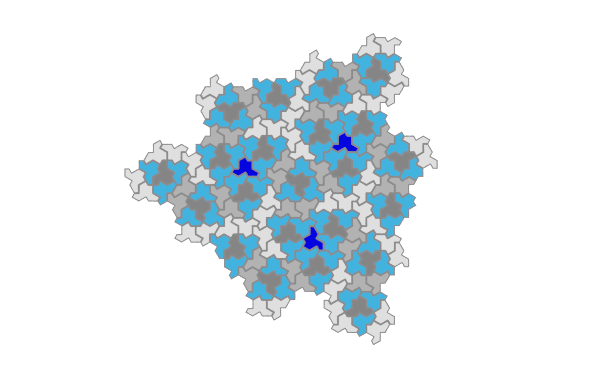

In [18]:
vertices_filename = os.path.join('shapes_2.txt')

scene = fresnel.Scene()

shape_data = parse_shapes(vertices_filename)

for vertices, shape_color, shape_type in zip(shape_data["vertices"], shape_data["colors"], shape_data["types"]):
    shape_color_linear = convert_colors_to_linear(shape_color)

    shape_material = fresnel.material.Material(
        color=shape_color_linear.flatten(), 
        roughness=0.1
    )

    outline_material = fresnel.material.Material(
        color=convert_colors_to_linear(color_map["grey"]).flatten()
    )

    fresnel.geometry.Polygon(
        scene,
        vertices,
        position=(0, 0),
        angle=0,
        color=shape_color_linear.flatten(),
        rounding_radius=0,
        material=shape_material,
        outline_material=outline_material,  
        outline_width=0.1 
    )

scene.camera = fresnel.camera.Orthographic.fit(scene)

fresnel.preview(scene)

In [15]:
N_particles = len(shape_data["types"]) 
N_particles

169